In [ ]:
'''This script examines several methods to for aspect modelling.
The models are then saved for predicting aspects for a new, unseen review.'''

# Import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


import pandas as pd
import numpy as np
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             hamming_loss, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from skmultilearn.model_selection import IterativeStratification

from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

import pyLDAvis
from pyLDAvis import gensim_models

pyLDAvis.enable_notebook()

# Define Functions

In [2]:
def stratified_split (X, Y, test_size):
    '''Stratified train-test split given specified test_size'''
    stratifier = IterativeStratification(n_splits=2, order=2,
                                         sample_distribution_per_fold=[test_size, 
                                                                       1-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, Y))
    X_train, Y_train = X[train_indexes], Y.iloc[train_indexes, :]
    X_test, Y_test = X[test_indexes], Y.iloc[test_indexes, :]
    return X_train, X_test, Y_train, Y_test


def evaluate_model(model, X_train, Y_train, n_folds=3):
    '''Evaluate a model using stratified k-fold cross-validation.
    prints out mean accuracy, mean hamming loss, and mean f1-score across folds'''
    acc_train = []
    acc_test = []
    loss_train = []
    loss_test = []
    f1_train = []
    f1_test =[]

    k_fold = IterativeStratification(n_splits=n_folds, order=2)

    for tr_index, ts_index in k_fold.split(X_train, Y_train):
        model.fit(X_train[tr_index], Y_train.iloc[tr_index])
        pred_train = model.predict(X_train[tr_index])
        pred_test = model.predict(X_train[ts_index])
        acc_train.append(accuracy_score(Y_train.iloc[tr_index], pred_train))
        acc_test.append(accuracy_score(Y_train.iloc[ts_index], pred_test))
        loss_train.append(hamming_loss(Y_train.iloc[tr_index], pred_train))
        loss_test.append(hamming_loss(Y_train.iloc[ts_index], pred_test))
        f1_train.append(f1_score(Y_train.iloc[tr_index], pred_train, average='micro'))
        f1_test.append(f1_score(Y_train.iloc[ts_index], pred_test, average='micro'))

    print('Train set:\n')
    print(f'Mean accuracy score: {np.mean(acc_train)}, \n'
          f'Mean loss: {np.mean(loss_train)}, \n'
          f'Mean F1-score:{np.mean(f1_train)}')
    print('\nTest set:\n')
    print(f'Mean accuracy score: {np.mean(acc_test)}, \n'
          f'Mean loss: {np.mean(loss_test)}, \n'
          f'Mean F1-score:{np.mean(f1_test)}')


def preprocess_text(text):
    '''Preprocess and convert a text into tokens for topic modeling'''
    text = remove_stopwords(text)
    tokens = simple_preprocess(text)
    tokens_lem = [WordNetLemmatizer().lemmatize(token, pos='v') for token in tokens]
    processed = [token for token in tokens_lem if len(token) > 3]
    return processed


def topic_aspect_corplot(topics_aspects):
    '''plots correlation between labelled aspects and extracted topics.'''
    labels = topics_aspects.columns
    mask = np.zeros_like(topics_aspects.corr())
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(22, 22))
    sns.heatmap(topics_aspects.corr(), 
                xticklabels=labels, 
                yticklabels=labels, 
                cmap="RdBu_r", 
                mask=mask,
                annot=True)
    plt.title('Correlation between aspects and topics', fontsize=30)
    plt.show()

# Load Data

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Multi-label Classification

## Text Vectorization

In [4]:
# Grid search for the max number of features with TfidfVectorizer
TVs = [TfidfVectorizer(max_features=100*i, ngram_range=(1,2), 
                       strip_accents='unicode', lowercase=True, 
                       stop_words='english') 
       for i in range(1, 11)]

Y = train.drop('review', axis=1)

scores = []
losses = []
for i in range(len(TVs)):
    X = TVs[i].fit_transform(train['review'])
    # Train-test split
    X_train, X_test, Y_train, Y_test = stratified_split(X, Y, test_size=0.3)
    # Training
    classifier = ClassifierChain(LogisticRegression(max_iter=5000, 
                                                    random_state=100))
    classifier.fit(X_train, Y_train)
    predicted = classifier.predict(X_test)
    scores.append(accuracy_score(Y_test, predicted))
    losses.append(hamming_loss(Y_test, predicted))

print(f'scores:\n{scores}')
print(f'losses:\n{losses}')

scores:
[0.468944099378882, 0.47210743801652894, 0.48190279214064113, 0.4674250258531541, 0.4581178903826267, 0.463768115942029, 0.463768115942029, 0.4612202688728025, 0.4575569358178054, 0.4616977225672878]
losses:
[0.1125776397515528, 0.10950413223140495, 0.11194415718717683, 0.11504653567735264, 0.12086349534643226, 0.11969461697722568, 0.12202380952380952, 0.12228541882109617, 0.1251293995859213, 0.1255175983436853]


## Training

In [5]:
# TfidfVectorizer with max_features=200
tv = TfidfVectorizer(max_features=200, ngram_range=(1, 2), 
                     strip_accents='unicode', lowercase=True, 
                     stop_words='english') 

X = tv.fit_transform(train['review'])
Y = train.drop('review', axis=1)

print(X.shape, Y.shape)

(3149, 200) (3149, 8)


In [6]:
model = ClassifierChain(LogisticRegression(max_iter=1000,
                                           random_state=100))
evaluate_model(model, X, Y, n_folds=3)

Train set:

Mean accuracy score: 0.5477922147972069, 
Mean loss: 0.09127749337545582, 
Mean F1-score:0.8316216565128375

Test set:

Mean accuracy score: 0.48774853036598004, 
Mean loss: 0.10682088744588746, 
Mean F1-score:0.8022024179685787


## Model Evaluation

In [7]:
model.fit(X, Y)
X_test = tv.transform(test['review'])
Y_test = test.drop('review', axis=1)
predicted = model.predict(X_test)

print(f'ROC AUC Score: {roc_auc_score(Y_test, model.predict_proba(X_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(Y_test, predicted, target_names=Y_test.columns)}')

ROC AUC Score: 0.9174369179204579


Classification Report
               precision    recall  f1-score   support

     ambience       1.00      0.50      0.67        32
         food       0.86      0.94      0.90       291
         menu       0.91      0.84      0.88        76
miscellaneous       0.85      0.49      0.62       136
        place       0.89      0.70      0.79        81
        price       0.89      0.42      0.57        38
      service       0.81      0.72      0.76        78
        staff       0.82      0.94      0.88       169

    micro avg       0.86      0.79      0.82       901
    macro avg       0.88      0.69      0.76       901
 weighted avg       0.86      0.79      0.81       901
  samples avg       0.86      0.80      0.82       901



In [8]:
# # Save supervised model
# joblib.dump(model, 'classifier.pkl')
# joblib.dump(tv, 'vectorizer.pkl')

# Topic Modeling
Unsupevised topic extraction is performed using 3 topic modeling methods:
1. Latent Dirichlet Allocation (LDA)
2. Non-negative Matrix Factorization (NMF) using Frobenius norm
3. NMF using generalized Kullback-Leibler divergence  

## 1. LDA

In [9]:
# Preprocess reviews for LDA
reviews_processed = [preprocess_text(review) for review in train['review']]
# Create dictionary and corpus
dictionary = corpora.Dictionary(reviews_processed)
# convert tokenized documents into a bag of words corpus
corpus_bow = [dictionary.doc2bow(review) for review in reviews_processed]
# Using TF-IDF instead of bag-of-words
tfidf = models.TfidfModel(corpus_bow) 
corpus_tfidf = tfidf[corpus_bow]

ldamodel = models.ldamodel.LdaModel(corpus_bow, num_topics=8,
                                    id2word=dictionary, passes=10, 
                                    random_state=12)
pprint(ldamodel.print_topics())

[(0,
  '0.015*"menu" + 0.014*"food" + 0.013*"know" + 0.012*"wine" + 0.011*"manager" '
  '+ 0.008*"service" + 0.008*"like" + 0.008*"host" + 0.008*"spill" + '
  '0.008*"didn"'),
 (1,
  '0.050*"wait" + 0.026*"food" + 0.020*"drink" + 0.018*"long" + 0.015*"table" '
  '+ 0.014*"service" + 0.014*"staff" + 0.011*"hour" + 0.009*"room" + '
  '0.009*"people"'),
 (2,
  '0.036*"order" + 0.034*"waiter" + 0.027*"waitress" + 0.023*"drink" + '
  '0.019*"come" + 0.018*"table" + 0.017*"take" + 0.016*"time" + '
  '0.015*"minutes" + 0.015*"wait"'),
 (3,
  '0.019*"good" + 0.017*"appetizer" + 0.010*"dinner" + 0.009*"menu" + '
  '0.009*"friend" + 0.007*"love" + 0.007*"steak" + 0.007*"want" + '
  '0.007*"serve" + 0.006*"place"'),
 (4,
  '0.048*"food" + 0.048*"service" + 0.021*"great" + 0.020*"menu" + '
  '0.018*"price" + 0.018*"dinner" + 0.017*"place" + 0.017*"good" + '
  '0.012*"restaurant" + 0.010*"average"'),
 (5,
  '0.041*"menu" + 0.015*"seat" + 0.015*"host" + 0.011*"table" + '
  '0.010*"reservation" + 0.0

In [10]:
# Visualization
gensim_models.prepare(ldamodel, corpus_bow, dictionary)

/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.184708 -0.081896       1        1  24.849079
4      0.156359 -0.080412       2        1  14.538935
1     -0.052882 -0.129143       3        1  14.196562
5     -0.059718  0.121703       4        1  12.720384
7     -0.040014 -0.036040       5        1  10.338923
6      0.149912 -0.049424       6        1   9.452832
0     -0.028929  0.128847       7        1   7.179251
3      0.059981  0.126365       8        1   6.724033, topic_info=           Term        Freq       Total Category  logprob  loglift
97         wait  383.000000  383.000000  Default  30.0000  30.0000
63        order  317.000000  317.000000  Default  29.0000  29.0000
26      service  395.000000  395.000000  Default  28.0000  28.0000
4          food  593.000000  593.000000  Default  27.0000  27.0000
111        menu  408.000000  408.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
99         come   11.816614  198.613743   Topic8  -5.1653  -0.1224
42        drink   10.499470  335.816302   Topic8  -5.2835  -0.7658
4          food   10.003670  593.424616   Topic8  -5.3319  -1.3835
470        know    8.766901   74.659937   Topic8  -5.4639   0.5575
344  atmosphere    8.706940   88.267337   Topic8  -5.4707   0.3832

[578 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2776      5  0.842773       accent
8         3  0.916243  accommodate
2299      8  0.788223   additional
1729      2  0.777332     adequate
1576      5  0.870507        admit
...     ...       ...          ...
1138      1  0.866576       wouldn
1182      2  0.470438        years
1182      7  0.470438        years
2551      5  0.781386         yell
2551      8  0.173641         yell

[1157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 6, 8, 7, 1, 4])

In [11]:
# extract topics probabilities for each review 
def get_topics_scores(corpus, doc_index, ldamodel):
    '''get the scores associated with all topics for a single review'''
    _, scores = list(zip(*ldamodel.get_document_topics(corpus[doc_index], 
                                                       minimum_probability=0.0)))
    return list(scores)

# organize the results (topics probabilities) for all reviews in a data frame
reviews_topics = [get_topics_scores(corpus_bow, doc_index, ldamodel) 
                  for doc_index in range(len(reviews_processed))]
reviews_topics = pd.DataFrame(reviews_topics)
reviews_topics.columns = ['lda_topic' + str(col) 
                          for col in reviews_topics.columns]
print(reviews_topics.shape)
reviews_topics.head()

(3149, 8)


,lda_topic0,lda_topic1,lda_topic2,lda_topic3,lda_topic4,lda_topic5,lda_topic6,lda_topic7
0,0.013922,0.013932,0.529431,0.013925,0.386931,0.013923,0.013937,0.013999
1,0.015638,0.437971,0.468214,0.015627,0.015629,0.015660,0.015628,0.015632
2,0.010434,0.010433,0.688364,0.010434,0.162120,0.010445,0.010429,0.097341
3,0.017863,0.017867,0.177532,0.017862,0.715292,0.017861,0.017860,0.017863
4,0.017876,0.017883,0.599396,0.017860,0.293340,0.017896,0.017874,0.017874


/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


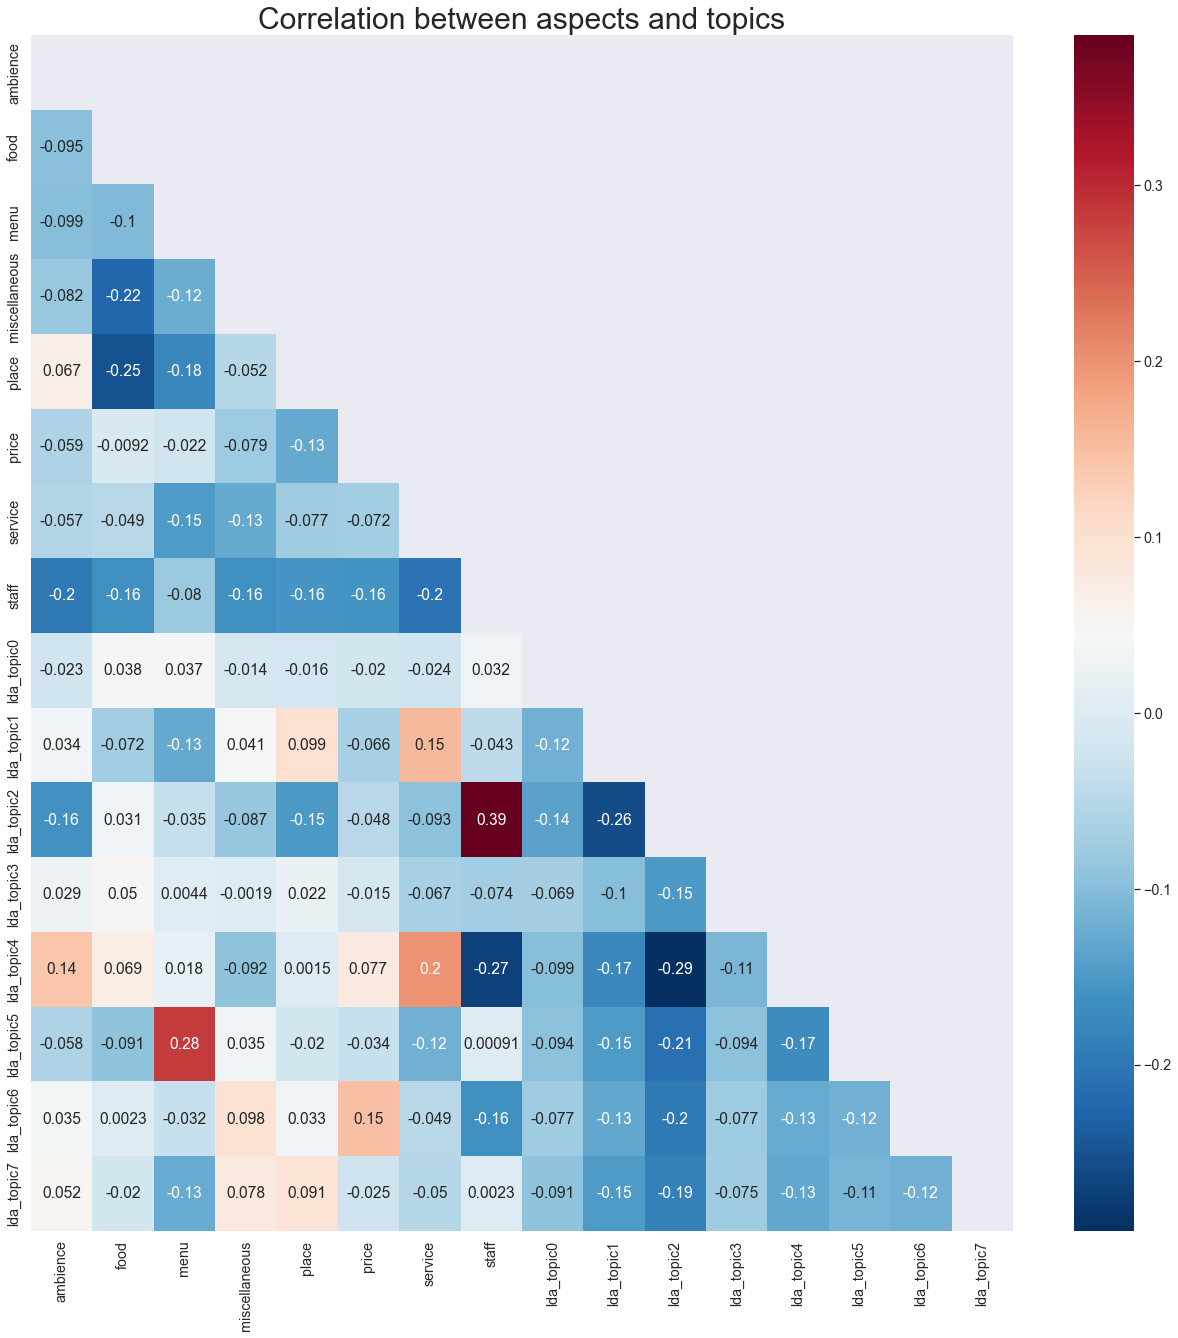

In [12]:
# Correlation between LDA topics and aspects
topics_aspects = pd.concat([train.drop('review', axis=1), reviews_topics], axis=1)
topic_aspect_corplot(topics_aspects)

In [13]:
# Assign aspects to topics 
ldaTopic_to_aspect = {
    0: [],
    1: ['service'],
    2: ['staff'],
    3: [],
    4: ['service', 'ambience'],
    5: ['menu'],
    6: ['price'],
    7: []
}

In [14]:
# Save the lda model
ldamodel.save('lda.model')

## 2. NMF using Frobenius norm

In [15]:
# use vectorized reviews, X (using tf-idf)
nmf_fn = NMF(n_components=8, random_state=123)
reviews_topics = nmf_fn.fit_transform(X)

# Convert to dataframe
reviews_topics = pd.DataFrame(reviews_topics)
reviews_topics.columns = ['nmf_fn_topic' + str(col) for col in reviews_topics.columns]
print(reviews_topics.shape)
reviews_topics.head()

(3149, 8)


,nmf_fn_topic0,nmf_fn_topic1,nmf_fn_topic2,nmf_fn_topic3,nmf_fn_topic4,nmf_fn_topic5,nmf_fn_topic6,nmf_fn_topic7
0,0.054505,0.000595,0.003061,0.029524,0.047626,0.000000,0.000804,0.001468
1,0.000753,0.000000,0.000000,0.000000,0.000000,0.050649,0.059106,0.000000
2,0.000000,0.007693,0.004573,0.000000,0.013103,0.031692,0.057117,0.005431
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.010909,0.000000,0.169572
4,0.000000,0.007982,0.005254,0.005372,0.005943,0.012226,0.090415,0.007385


/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


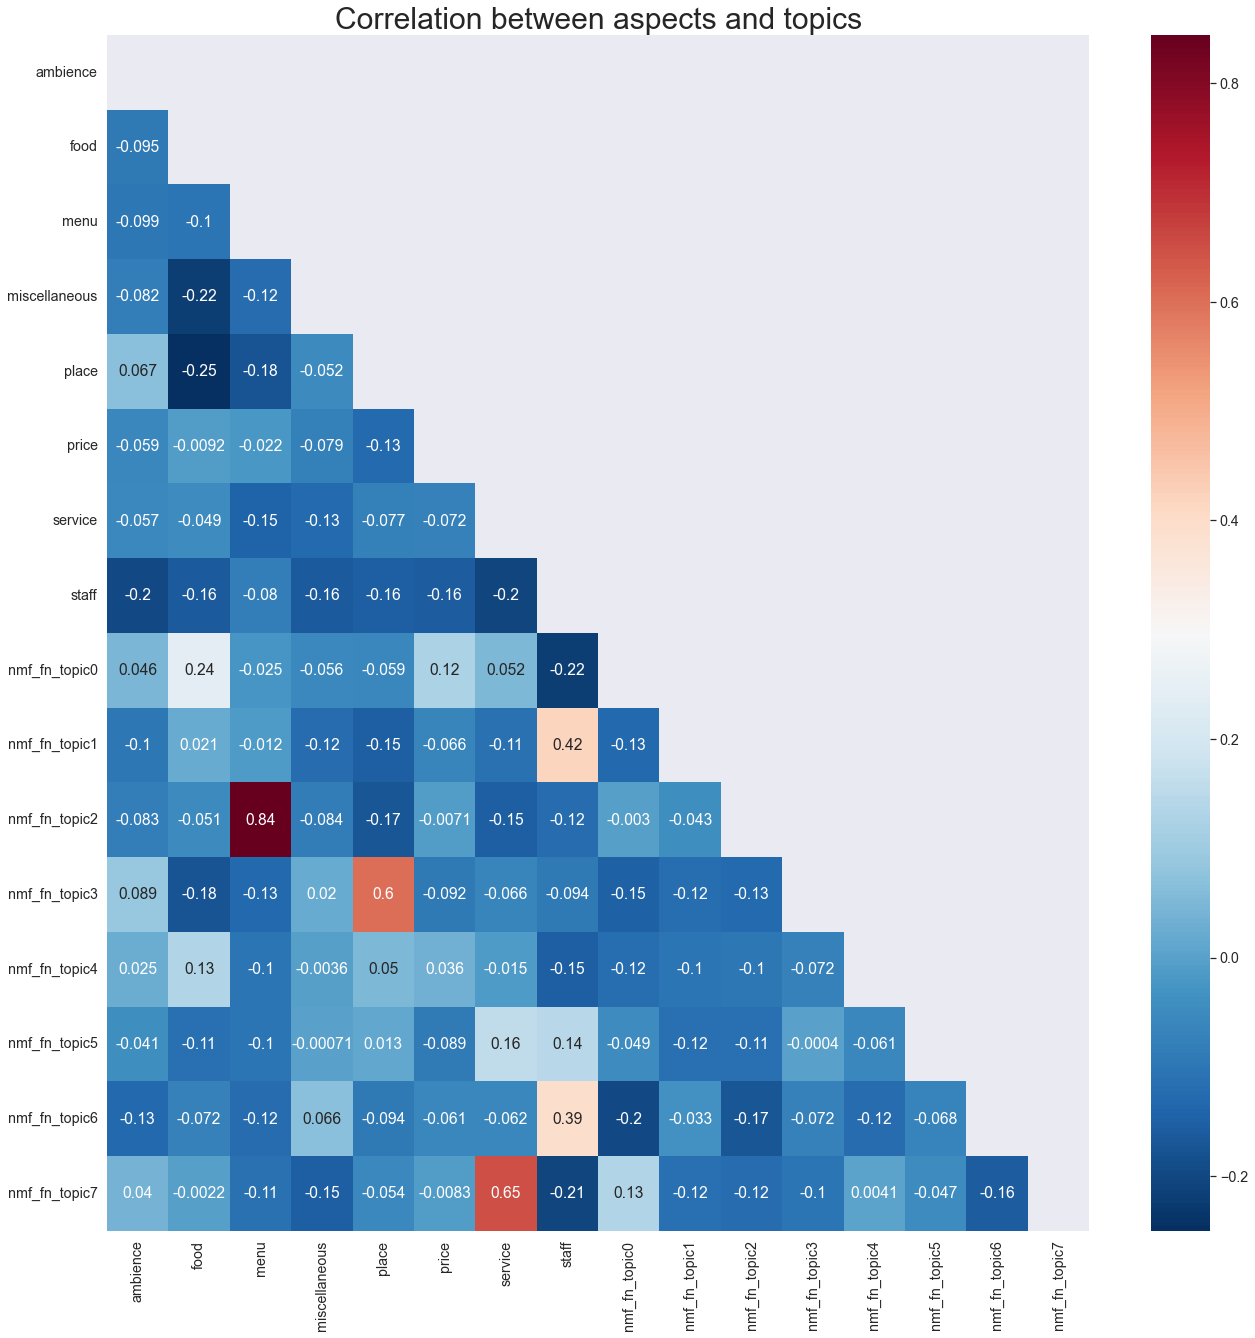

In [16]:
# Correlation between topics and aspects
topics_aspects = pd.concat([train.drop('review', axis=1), reviews_topics], axis=1)
topic_aspect_corplot(topics_aspects)

In [17]:
# Assign aspects to topics 
nmf_fnTopic_to_aspect = {
    0: [],
    1: ['staff'],
    2: ['menu'],
    3: ['place'],
    4: [],
    5: [],
    6: ['staff'], 
    7: ['service']
}

In [18]:
# Save the model
joblib.dump(nmf_fn, 'nmf_fn.pkl');

## 3. NMF using generalized Kullback-Leibler divergence

/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


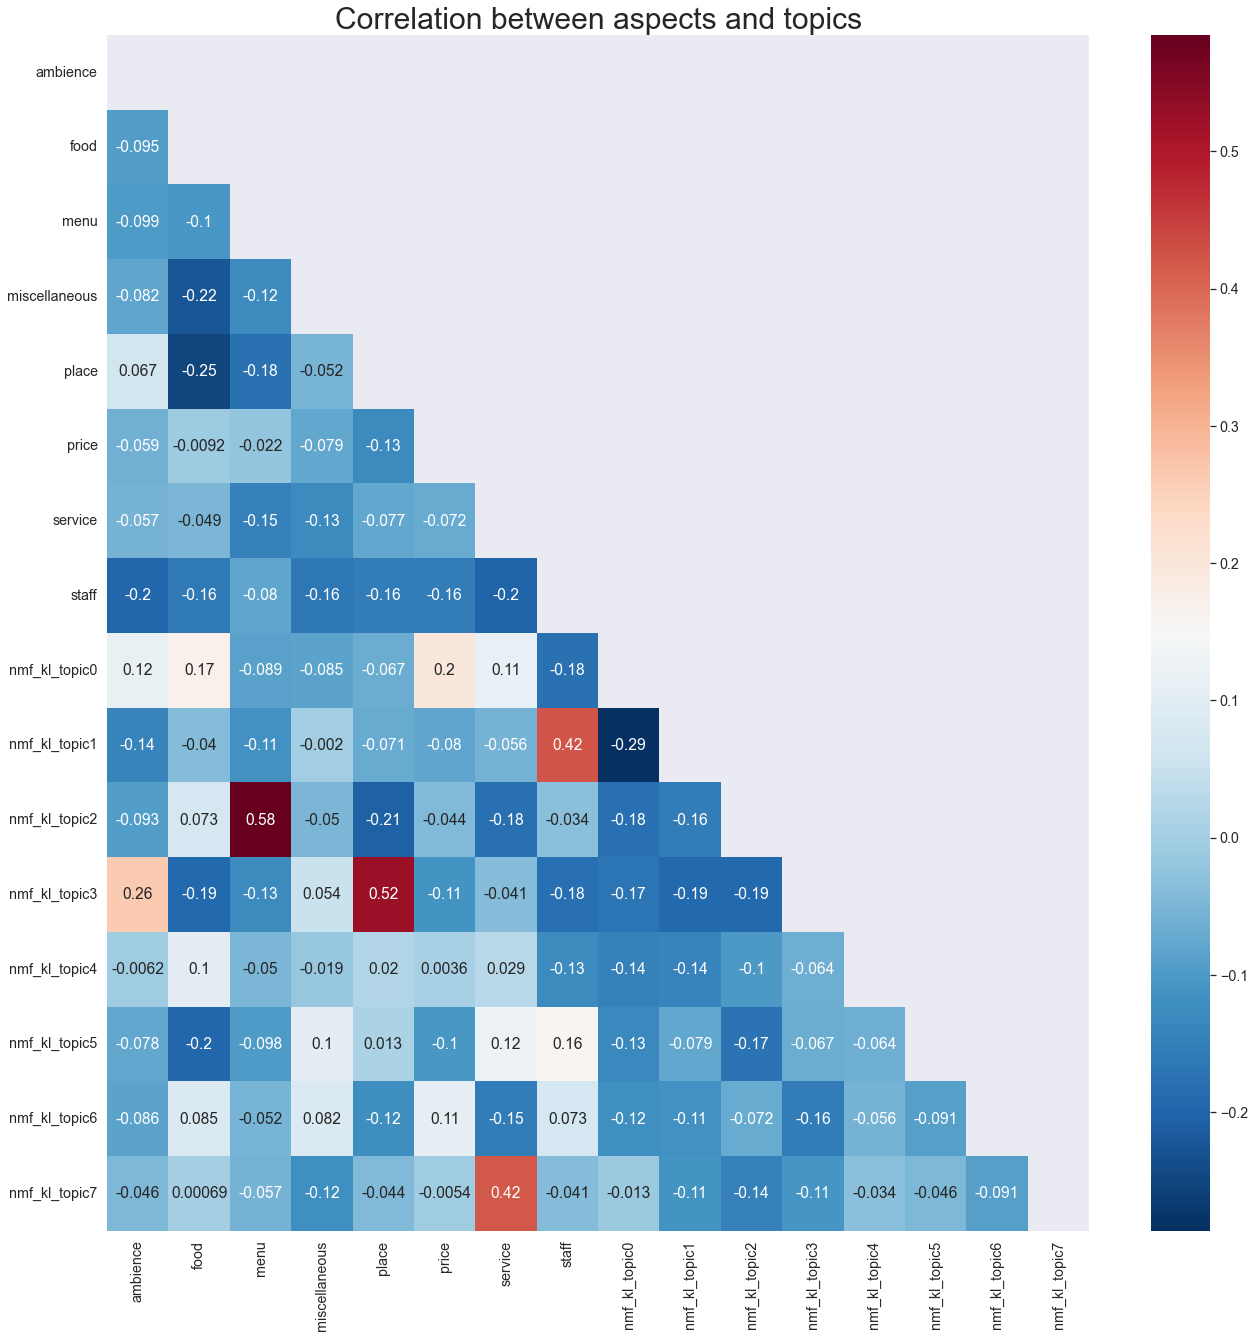

In [19]:
nmf_kl = NMF(n_components=8, random_state=123, beta_loss="kullback-leibler",
             solver="mu", max_iter=1000)

reviews_topics = nmf_kl.fit_transform(X)
reviews_topics = pd.DataFrame(reviews_topics)
reviews_topics.columns = ['nmf_kl_topic' + str(col) for col in reviews_topics.columns]

topics_aspects = pd.concat([train.drop('review', axis=1), reviews_topics], axis=1)
topic_aspect_corplot(topics_aspects)

In [20]:
# Assign aspects to topics 
nmf_klTopic_to_aspect = {
    0: ['price', 'food'],
    1: ['staff'],
    2: ['menu'],
    3: ['place', 'ambience'],
    4: [],
    5: [],
    6: [],
    7: ['service']
}

In [21]:
# Save the  model
joblib.dump(nmf_fn, 'nmf_kl.pkl');